**Machine Learning for Time Series (Master MVA)**

- Tutorial 2, Friday 29<sup>th</sup> January 2021
- [Link to the class material.](http://www.laurentoudre.fr/ast.html)

# Introduction

In this tutorial, we illustrate the following concepts:

- feature extraction on time series
- feature selection

## Setup

**Imports**

In [1]:
from itertools import tee

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from loadmydata.load_uea_ucr import load_uea_ucr_data
from numpy.fft import rfft, rfftfreq
from scipy.cluster import hierarchy
from scipy.signal import argrelmax, stft
from scipy.spatial.distance import pdist, squareform
from scipy.stats import f_oneway, spearmanr, kurtosis, skew
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.neighbors import KNeighborsClassifier
from statsmodels.tsa.stattools import acf

**Utility functions**

In [2]:
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

In [3]:
def get_largest_local_max(signal1D: np.ndarray, order: int = 1):
    """Return the largest local max and the associated index in a tuple.

    This function uses `order` points on each side to use for the comparison.
    """
    all_local_max_indexes = argrelmax(signal1D, order=order)[0]
    all_local_max = np.take(signal1D, all_local_max_indexes)
    largest_local_max_index = all_local_max_indexes[
        all_local_max.argsort()[-1]
    ]

    return signal1D[largest_local_max_index], largest_local_max_index

In [4]:
def fig_ax(figsize=(15, 5)):
    return plt.subplots(figsize=figsize)

## Data

In [5]:
dataset_name = "BinaryHeartbeat"
data = load_uea_ucr_data(dataset_name)
print(data.description)

Task is to classify the nature of the heartbeat signal.

Heart sound recordings were sourced from several contributors around the world, collected at either a clinical or nonclinical environment, from both healthy subjects and pathological patients.
Each series represent the aplitude of the singal over time.

Heart sound recordings were sourced from several contributors around the world, collected at either a clinical or nonclinical environment, from both healthy subjects and pathological patients.
The heart sound recordings were collected from different locations on the body. The typical four locations are aortic area, pulmonic area, tricuspid area and mitral area, but could be one of nine different locations.
The sounds were divided into two classes: normal and abnormal. The normal recordings were from healthy subjects and the abnormal ones were from patients with a confirmed cardiac diagnosis.
The patients suffer from a variety of illnesses, but typically they are heart valve defect

In [6]:
# Sampling frequency
FREQUENCY = 2000  # Hz

Choose a signal from the data set.

In [7]:
signal = data.X_train[0].flatten()
n_samples = signal.shape[0]

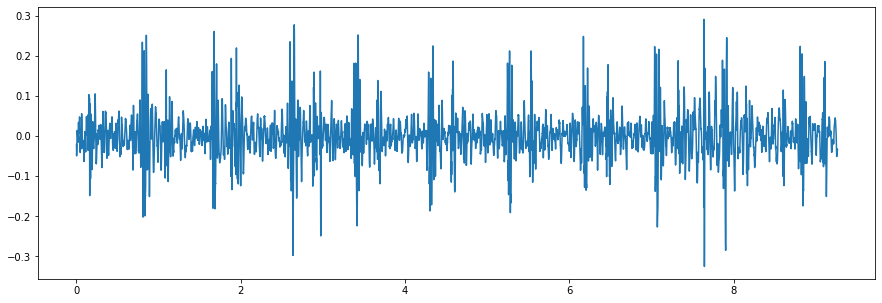

In [8]:
fig, ax = fig_ax()
tt = np.arange(n_samples) / FREQUENCY
ax.plot(tt, signal)

Compute the spectrogram


In [9]:
f, t, Zxx = stft(signal, fs=FREQUENCY, nperseg=1000, noverlap=800)

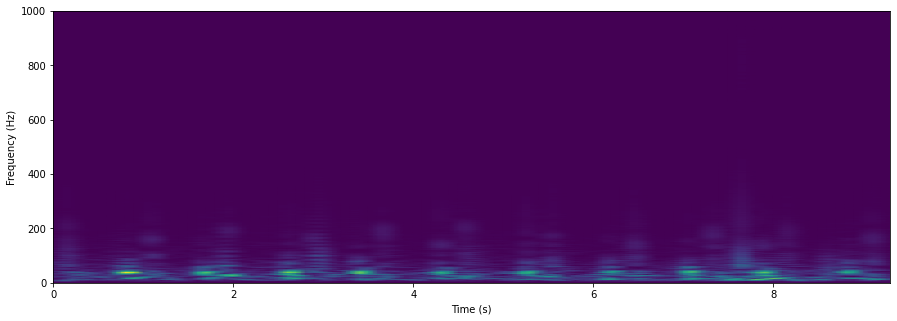

In [10]:
fig, ax = fig_ax()
ax.pcolormesh(t, f, np.abs(Zxx), vmin=0, shading="gouraud")
ax.set_xlabel("Time (s)")
_ = ax.set_ylabel("Frequency (Hz)")

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Replot the same spectrogram as above, but zoom on the interesting frequencies (set <tt>cut_off_freq</tt> in the following cell).</p>
    <ul>
        <li>What are the repeated patterns? What is the frequency of interest (approximately)?</li>
        <li>What happens when you increase the number of samples per windows?</li>
        <li>What happens when you increase the overlap between windows?</li>
    </ul>
</div>

In [11]:
# Cut-off frequency
cut_off_freq = 100  # Hz

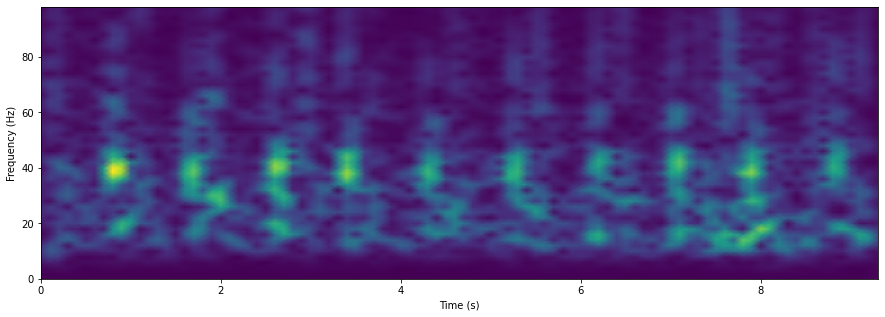

In [12]:
fig, ax = fig_ax()

f, t, Zxx = stft(signal, fs=FREQUENCY, nperseg=1000, noverlap=800)

keep_mask = f < cut_off_freq

ax.pcolormesh(
    t, f[keep_mask], np.abs(Zxx[keep_mask]), vmin=0, shading="gouraud"
)
ax.set_xlabel("Time (s)")
_ = ax.set_ylabel("Frequency (Hz)")

There is a repeated pattern around a frequence of 40Hz (and maybe 20 Hz) every seconds (Match with the heartbeat).

When we increase the number of samples per window, the image becomes more blurry. (A fft is not really useful if the signal changes to much on the window. This is what occurs here)

When we increase the overlap between windows, following windows tends to have the same fft. We get a smoother spectrogram.

# Feature extraction

## Statistical features

### Moments and percentiles

In [13]:
def get_distribution_features(signal: np.ndarray) -> dict:
    res_dict = dict()
    res_dict["mean"] = signal.mean()
    res_dict["std"] = signal.std()
    res_dict["min"] = signal.min()
    res_dict["max"] = signal.max()
    return res_dict

In [14]:
get_distribution_features(signal)

{'mean': -4.36204926670265e-05,
 'std': 0.053476347507460366,
 'min': -0.3250732,
 'max': 0.2915039}

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p> Rewrite in the following cell, the function <tt>get_distribution_features(signal)->dict</tt> so that is also computes the kurtosis, the skew (available in the <tt>scipy.stats</tt> module) and the 25%, 50% and 75% percentiles.</p>
</div>

In [15]:
def get_distribution_features(signal: np.ndarray) -> dict:
    res_dict = dict()
    res_dict["mean"] = signal.mean()
    res_dict["std"] = signal.std()
    res_dict["min"] = signal.min()
    res_dict["max"] = signal.max()
    res_dict["kurtosis"] = kurtosis(signal)
    res_dict["skew"] = skew(signal)
    res_dict["25"] = np.percentile(signal, 25)
    res_dict["50"] = np.percentile(signal, 50)
    res_dict["75"] = np.percentile(signal, 75)
    return res_dict

get_distribution_features(signal)

{'mean': -4.36204926670265e-05,
 'std': 0.053476347507460366,
 'min': -0.3250732,
 'max': 0.2915039,
 'kurtosis': 4.395775251359628,
 'skew': 0.28696295903662516,
 '25': -0.02713013,
 '50': -0.0006103516,
 '75': 0.02511597}

### Autocorrelation

For a signal $x\in\mathbb{R}^N$ with $N$ samples, the autocorrelation with lag $m$ is defined as follows:

$$
\hat{\gamma}[m] := \frac{1}{N-|m|} \sum_{n=0}^{N-1} x[n]x[n+m].
$$

Note that if the signal $x$ is periodic, then the autocorrelation is also periodic with same period.

Let us plot the autocorrelation of a sound signal.

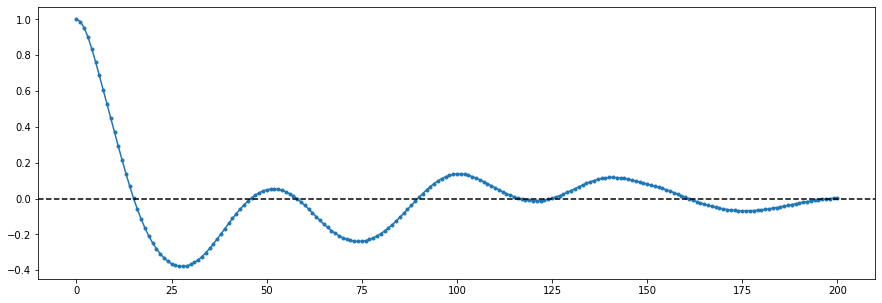

In [16]:
fig, ax = fig_ax()
ax.plot(acf(signal, nlags=200, fft=True), ".-")
ax.axhline(0, ls="--", color="k")
plt.show()

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>We would like to also compute the maximum autocorrelation value and the associated lag in Hz (a local maximum that is not 0). Explain how you can convert a lag expressed in number of samples to a lag expressed in Hz.</p>
</div>

The lag that we will get will be in number of samples. We can expressed it in Hz directly by using the sampling frequency of the signal f: lag_hz = f / lag_n


Compute the autocorrelation features.

In [17]:
def get_autocorr_features(signal: np.ndarray, n_lags: int = 200) -> dict:
    auto_corr = acf(signal, nlags=n_lags, fft=True)
    res_dict = dict()
    for (lag, auto_corr_value) in enumerate(auto_corr):
        res_dict[f"autocorrelation_{lag}_lag"] = auto_corr_value

    local_max, local_argmax = get_largest_local_max(auto_corr, order=1)
    res_dict["lag_max_autocorrelation_Hz"] = FREQUENCY / local_argmax
    res_dict["max_autocorrelation"] = local_max

    return res_dict

In [18]:
get_autocorr_features(signal, n_lags=100)

{'autocorrelation_0_lag': 1.0,
 'autocorrelation_1_lag': 0.9878346636837038,
 'autocorrelation_2_lag': 0.9539436420458182,
 'autocorrelation_3_lag': 0.9019015664004297,
 'autocorrelation_4_lag': 0.8371394434711026,
 'autocorrelation_5_lag': 0.7642879203951046,
 'autocorrelation_6_lag': 0.6869953069390051,
 'autocorrelation_7_lag': 0.6077263361362768,
 'autocorrelation_8_lag': 0.5278428777248149,
 'autocorrelation_9_lag': 0.44807529893529446,
 'autocorrelation_10_lag': 0.36878531428200517,
 'autocorrelation_11_lag': 0.2904319128393836,
 'autocorrelation_12_lag': 0.2135843409306105,
 'autocorrelation_13_lag': 0.1391579881199314,
 'autocorrelation_14_lag': 0.0681155536375731,
 'autocorrelation_15_lag': 0.00153175607494485,
 'autocorrelation_16_lag': -0.05982668166177405,
 'autocorrelation_17_lag': -0.11537747797593947,
 'autocorrelation_18_lag': -0.1650154245069034,
 'autocorrelation_19_lag': -0.20879735631315996,
 'autocorrelation_20_lag': -0.24706403734001328,
 'autocorrelation_21_lag':

## Spectral features

Plot the Fourier coefficients of a signal (y=absolute value, x=frequency) using `rfft()` and `rfftfreq()`.

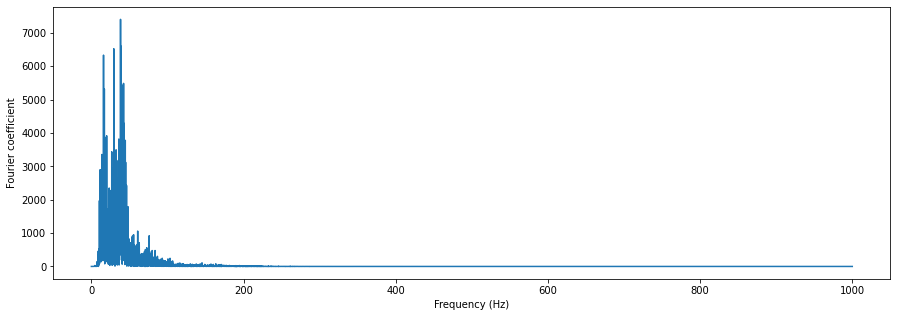

In [19]:
fourier = abs(rfft(signal)) ** 2
freqs = rfftfreq(n=n_samples, d=1.0 / FREQUENCY)

fig, ax = fig_ax()
ax.plot(freqs, fourier)
ax.set_xlabel("Frequency (Hz)")
_ = ax.set_ylabel("Fourier coefficient")

Compute the spectral features.

In [20]:
def get_fourier_features(signal: np.ndarray, n_bins: int = 100) -> dict:
    """The signal is assumed to be centered and scaled to unit variance."""

    n_samples = signal.shape[0]
    fourier = abs(rfft(signal))
    freqs = rfftfreq(n=n_samples, d=1.0 / FREQUENCY)
    res_dict = dict()

    freq_bins = np.linspace(0, FREQUENCY / 2, n_bins + 1)
    for (f_min, f_max) in pairwise(freq_bins):
        keep = (f_min <= freqs) & (freqs < f_max)
        res_dict[f"fourier_{f_min:.1f}-{f_max:.1f}_Hz"] = np.log(
            np.sum(fourier[keep] ** 2)
        )
    return res_dict

In [21]:
get_fourier_features(signal, n_bins=10)

{'fourier_0.0-100.0_Hz': 13.062805200766368,
 'fourier_100.0-200.0_Hz': 9.789782046195757,
 'fourier_200.0-300.0_Hz': 7.474775836054673,
 'fourier_300.0-400.0_Hz': 5.042830727182429,
 'fourier_400.0-500.0_Hz': 3.271908511560872,
 'fourier_500.0-600.0_Hz': 2.034724789695899,
 'fourier_600.0-700.0_Hz': 2.072603298867695,
 'fourier_700.0-800.0_Hz': 2.6515556177815025,
 'fourier_800.0-900.0_Hz': 2.993208438886878,
 'fourier_900.0-1000.0_Hz': 3.172705345844466}

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>The frequency features are not scaled. If the signal is normalized, do we need to?</p>
</div>

No, by Perseval identity, the norm of the signal is equal to the norm of the fourrier coefficients.

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p> We have used regularly spaced frequency bins. What would be a better approach? </p>

</div>

We should have use more bins for the important frequency (between 0 and 100 Hz)

## Concatenate all features

In the following cell, we write a function `get_features(signal: np.ndarray) -> dict` that computes all features from above.

In [22]:
def get_features(signal: np.ndarray) -> dict:
    res_dict = dict()

    # stats
    res_dict.update(get_distribution_features(signal))

    # spectral
    signal -= signal.mean()
    signal /= signal.std()
    res_dict.update(get_fourier_features(signal, n_bins=50))

    # autocorrelation
    res_dict.update(get_autocorr_features(signal, n_lags=200))

    return res_dict

In [23]:
get_features(signal)

{'mean': -4.36204926670265e-05,
 'std': 0.053476347507460366,
 'min': -0.3250732,
 'max': 0.2915039,
 'kurtosis': 4.395775251359628,
 'skew': 0.28696295903662516,
 '25': -0.02713013,
 '50': -0.0006103516,
 '75': 0.02511597,
 'fourier_0.0-20.0_Hz': 17.425511109475327,
 'fourier_20.0-40.0_Hz': 18.08989281619167,
 'fourier_40.0-60.0_Hz': 17.489366231711315,
 'fourier_60.0-80.0_Hz': 16.265620325645486,
 'fourier_80.0-100.0_Hz': 15.412438705688363,
 'fourier_100.0-120.0_Hz': 14.740121990157501,
 'fourier_120.0-140.0_Hz': 14.11903917348016,
 'fourier_140.0-160.0_Hz': 13.870068979262031,
 'fourier_160.0-180.0_Hz': 13.582886659613838,
 'fourier_180.0-200.0_Hz': 13.157674451752792,
 'fourier_200.0-220.0_Hz': 12.67154916631504,
 'fourier_220.0-240.0_Hz': 11.825080871850867,
 'fourier_240.0-260.0_Hz': 11.255058694087516,
 'fourier_260.0-280.0_Hz': 10.84329864883104,
 'fourier_280.0-300.0_Hz': 10.39955950521556,
 'fourier_300.0-320.0_Hz': 9.890567601073455,
 'fourier_320.0-340.0_Hz': 9.58705281499

Compute all features over the data set.

In [24]:
all_features = pd.DataFrame(
    [get_features(signal.data.flatten()) for signal in data.X_train]
)

In [25]:
all_features

,mean,std,min,max,kurtosis,skew,25,50,75,fourier_0.0-20.0_Hz,...,autocorrelation_193_lag,autocorrelation_194_lag,autocorrelation_195_lag,autocorrelation_196_lag,autocorrelation_197_lag,autocorrelation_198_lag,autocorrelation_199_lag,autocorrelation_200_lag,lag_max_autocorrelation_Hz,max_autocorrelation
0,-0.000044,0.053476,-0.325073,0.291504,4.395775,0.286963,-0.027130,-0.000610,0.025116,17.425511,...,-0.013568,-0.010462,-0.007693,-0.005201,-0.002915,-0.000772,0.001283,0.003267,20.000000,0.136663
1,-0.000026,0.021232,-0.109467,0.139496,4.207598,0.389185,-0.011505,-0.000244,0.010864,17.947738,...,0.147982,0.143621,0.139093,0.134445,0.129681,0.124822,0.119951,0.115106,10.869565,0.169397
2,-0.000069,0.034245,-0.253387,0.291596,22.093219,1.362185,-0.007721,-0.000031,0.007477,15.761979,...,0.007707,0.006197,0.004491,0.002655,0.000759,-0.001193,-0.003117,-0.005015,40.816327,0.113092
3,-0.000026,0.075533,-0.440369,0.644653,15.069250,1.424710,-0.020012,-0.000275,0.018646,15.773631,...,0.003933,0.008041,0.011920,0.015518,0.018804,0.021765,0.024399,0.026711,30.769231,0.159935
4,-0.000021,0.126608,-1.000000,0.999969,20.218365,0.238795,-0.017639,0.000275,0.016685,15.738893,...,0.025114,0.024158,0.023134,0.022036,0.020845,0.019556,0.018152,0.016617,37.037037,0.283012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,-0.000015,0.032546,-0.242615,0.205414,8.513986,-0.104041,-0.009369,-0.000214,0.009186,16.177246,...,0.028165,0.031262,0.033769,0.035721,0.037127,0.038019,0.038402,0.038395,28.571429,0.372528
200,0.000016,0.043400,-0.271423,0.268433,6.146150,0.385208,-0.017853,-0.001068,0.015930,17.137829,...,-0.022602,-0.024940,-0.026746,-0.028053,-0.028886,-0.029261,-0.029207,-0.028744,23.809524,0.155785
201,-0.000140,0.022984,-0.150848,0.155762,10.329968,-0.153763,-0.009125,0.000549,0.009155,17.238087,...,0.072303,0.069616,0.066457,0.062866,0.058874,0.054534,0.049894,0.045040,18.867925,0.087918
202,-0.000051,0.079495,-0.745911,0.765869,21.540629,0.662124,-0.016571,-0.000122,0.014435,16.915178,...,0.002492,0.002306,0.002059,0.001747,0.001358,0.000929,0.000435,-0.000088,25.000000,0.079607


<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p> How many features do we have in the end?</p>
</div>

We have 262 features.

# Feature selection

## Unsupervised selection

### Sanity checks

#### Low variance threshold

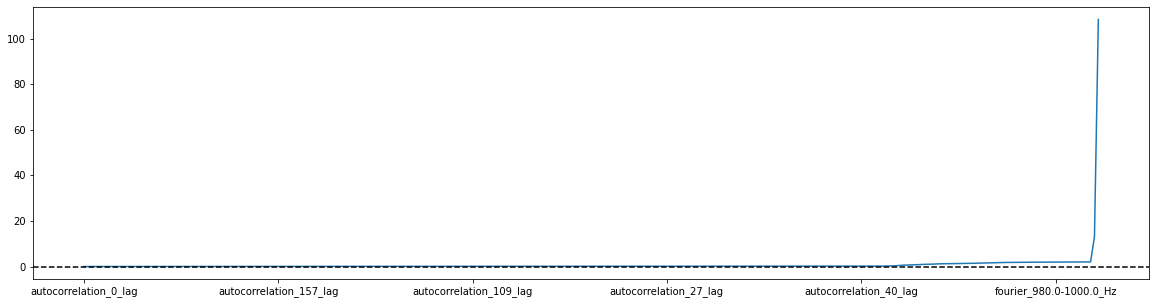

In [26]:
fig, ax = fig_ax(figsize=(20, 5))
all_features.std().sort_values().plot(ax=ax)

# change the height of the horizontal line here
ax.axhline(0.01, ls="--", color="k")

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p> Choose a variance threshold (name it <tt>variance_threshold</tt>).</p>
</div>

In [27]:
variance_threshold = 0.05

Be careful when dropping low variance features, they might still be informative. Quickly check that it makes sense to drop them.

In [28]:
low_variance_features = all_features.std() < variance_threshold
low_variance_features = low_variance_features[
    low_variance_features
].index.to_numpy()
print(f"There are {len(low_variance_features)} features to drop.")
print(low_variance_features)

There are 30 features to drop.
['mean' '25' '50' '75' 'autocorrelation_0_lag' 'autocorrelation_170_lag'
 'autocorrelation_171_lag' 'autocorrelation_172_lag'
 'autocorrelation_173_lag' 'autocorrelation_174_lag'
 'autocorrelation_175_lag' 'autocorrelation_176_lag'
 'autocorrelation_177_lag' 'autocorrelation_178_lag'
 'autocorrelation_179_lag' 'autocorrelation_180_lag'
 'autocorrelation_181_lag' 'autocorrelation_182_lag'
 'autocorrelation_183_lag' 'autocorrelation_184_lag'
 'autocorrelation_185_lag' 'autocorrelation_186_lag'
 'autocorrelation_187_lag' 'autocorrelation_188_lag'
 'autocorrelation_189_lag' 'autocorrelation_190_lag'
 'autocorrelation_191_lag' 'autocorrelation_192_lag'
 'autocorrelation_193_lag' 'autocorrelation_194_lag']


The following cell drops the low-variance features. Only execute it when you are sure of the features you want to remove.

In [29]:
all_features.drop(columns=low_variance_features, inplace=True, errors="ignore")
print(f"There are {all_features.shape[1]} features left.")

There are 232 features left.


#### Check outliers

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p> One feature has larger variations than the others: which one is it? (Name it <tt>feature_to_check</tt>.) Show the associated boxplot.</p>
</div>

In [30]:
 all_features.std().sort_values()

autocorrelation_195_lag         0.050136
autocorrelation_169_lag         0.050373
autocorrelation_196_lag         0.050435
autocorrelation_197_lag         0.050668
autocorrelation_168_lag         0.050790
                                 ...    
fourier_820.0-840.0_Hz          2.005509
fourier_880.0-900.0_Hz          2.028692
fourier_840.0-860.0_Hz          2.039035
kurtosis                       13.042616
lag_max_autocorrelation_Hz    108.410883
Length: 232, dtype: float64

In [32]:
feature_to_check = "lag_max_autocorrelation_Hz"

<AxesSubplot:>

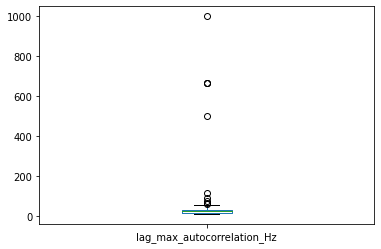

In [33]:
all_features[feature_to_check].plot(kind="box")

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p> Check the outliers. Is there something we can do to remediate this issue?</p>
</div>

In [35]:
all_features[feature_to_check][all_features[feature_to_check] > 700]

179    1000.0
Name: lag_max_autocorrelation_Hz, dtype: float64

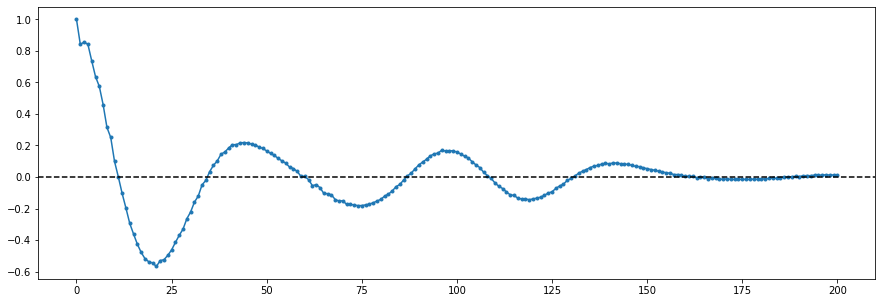

In [36]:
outlier = data.X_train[179].flatten()
fig, ax = fig_ax()
ax.plot(acf(outlier, nlags=200, fft=True), ".-")
ax.axhline(0, ls="--", color="k")
plt.show()

We are too sensitive to noise in the autocorrelation computation. We can change the order argument to compute more reliable local maximums. (Let's use order = 20)

This reduces our problem, but nonetheless this feature has still a lot more variability than the other features

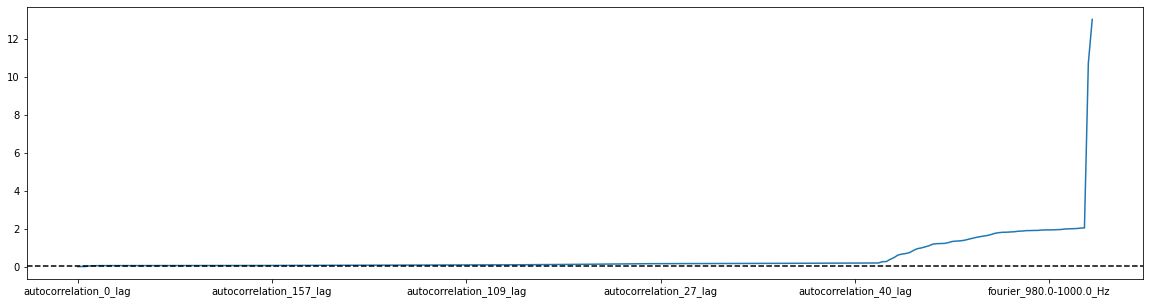

In [38]:
# Rebuild features with the new autocorr function.

def get_autocorr_features(signal: np.ndarray, n_lags: int = 200) -> dict:
    auto_corr = acf(signal, nlags=n_lags, fft=True)
    res_dict = dict()
    for (lag, auto_corr_value) in enumerate(auto_corr):
        res_dict[f"autocorrelation_{lag}_lag"] = auto_corr_value

    local_max, local_argmax = get_largest_local_max(auto_corr, order=20)
    res_dict["lag_max_autocorrelation_Hz"] = FREQUENCY / local_argmax
    res_dict["max_autocorrelation"] = local_max

    return res_dict

all_features = pd.DataFrame(
    [get_features(signal.data.flatten()) for signal in data.X_train]
)

fig, ax = fig_ax(figsize=(20, 5))
all_features.std().sort_values().plot(ax=ax)

# change the height of the horizontal line here
ax.axhline(0.01, ls="--", color="k")

In [39]:
# Redrop the features

low_variance_features = all_features.std() < variance_threshold
low_variance_features = low_variance_features[
    low_variance_features
].index.to_numpy()
all_features.drop(columns=low_variance_features, inplace=True, errors="ignore")
print(f"There are {all_features.shape[1]} features left.")

There are 232 features left.


### Multicollinearity

Multicollinearity degrades numerical stability and interpretability.
Compute the rank-based Spearman correlation.
Features with a correlation above a threshold are grouped together in a cluster.
We then choose a single feature from each cluster.

In [40]:
correlation_threshold = 0.8

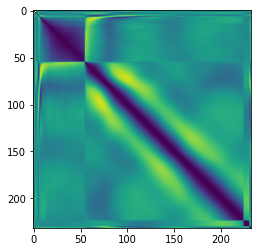

In [41]:
corr = pdist(
    all_features.to_numpy().T, metric="correlation"
)  # distance matrix
plt.imshow(squareform(corr))

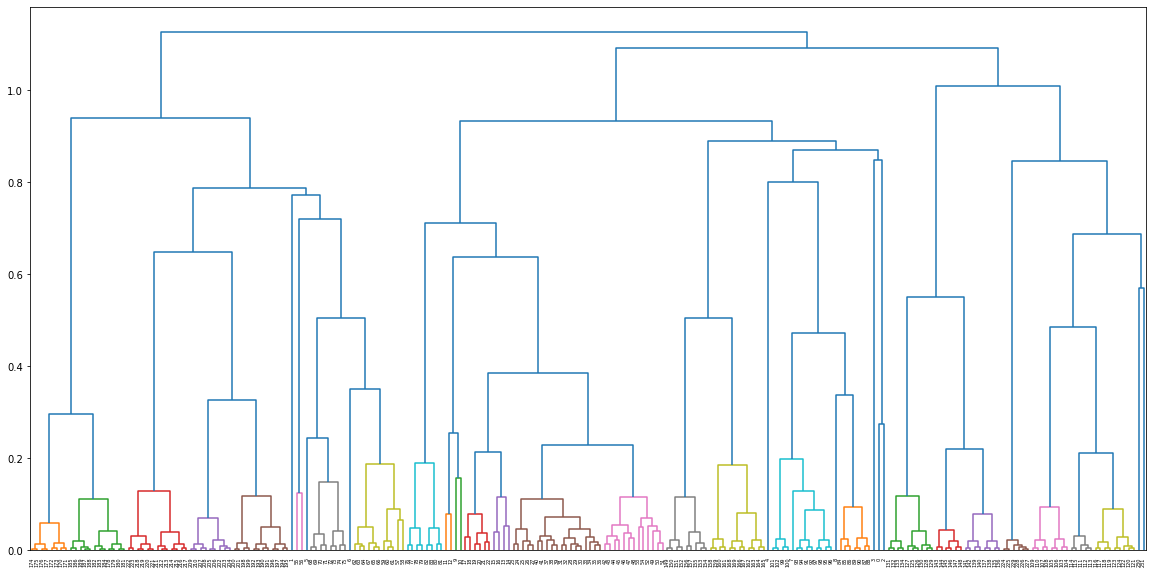

In [42]:
fig, ax = fig_ax((20, 10))
corr_linkage = hierarchy.average(corr)
dendro = hierarchy.dendrogram(
    corr_linkage, ax=ax, color_threshold=1 - correlation_threshold
)

In [43]:
# compute the clusters
cluster_ids = hierarchy.fcluster(
    corr_linkage, 1 - correlation_threshold, criterion="distance"
)

# print the largest clusters
largest_cluster_ind = np.bincount(cluster_ids).argmax()
print(
    f"The largest cluster is {all_features.columns[cluster_ids==largest_cluster_ind].tolist()}."
)

# for each cluster, only keep the first feature
keep_features = list()
for cluster in np.unique(cluster_ids):
    cluster_indexes = np.where(cluster_ids == cluster)[0]
    keep_features.append(all_features.columns[cluster_indexes[0]])

The largest cluster is ['fourier_360.0-380.0_Hz', 'fourier_380.0-400.0_Hz', 'fourier_400.0-420.0_Hz', 'fourier_420.0-440.0_Hz', 'fourier_440.0-460.0_Hz', 'fourier_460.0-480.0_Hz', 'fourier_480.0-500.0_Hz', 'fourier_500.0-520.0_Hz', 'fourier_520.0-540.0_Hz', 'fourier_540.0-560.0_Hz', 'fourier_560.0-580.0_Hz', 'fourier_580.0-600.0_Hz', 'fourier_600.0-620.0_Hz', 'fourier_620.0-640.0_Hz', 'fourier_640.0-660.0_Hz', 'fourier_660.0-680.0_Hz', 'fourier_680.0-700.0_Hz', 'fourier_700.0-720.0_Hz', 'fourier_720.0-740.0_Hz'].


In [44]:
# Reduce the number of features
all_features = all_features[keep_features]

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p> How many features do we have in the end?</p>
</div>

In [45]:
all_features

,autocorrelation_116_lag,autocorrelation_124_lag,autocorrelation_157_lag,autocorrelation_148_lag,autocorrelation_136_lag,autocorrelation_1_lag,autocorrelation_14_lag,fourier_0.0-20.0_Hz,autocorrelation_3_lag,fourier_20.0-40.0_Hz,...,kurtosis,autocorrelation_71_lag,autocorrelation_89_lag,autocorrelation_81_lag,autocorrelation_195_lag,autocorrelation_49_lag,autocorrelation_57_lag,autocorrelation_62_lag,lag_max_autocorrelation_Hz,max_autocorrelation
0,0.002822,-0.004444,0.033118,0.091998,0.100449,0.987835,0.068116,17.425511,0.901902,18.089893,...,4.395775,-0.227808,-0.015753,-0.181166,-0.007693,0.041672,0.014352,-0.079711,20.000000,0.136663
1,-0.053694,-0.013618,0.111687,0.089478,0.034492,0.989670,0.262726,17.947738,0.925658,17.998736,...,4.207598,-0.131929,-0.161592,-0.173309,0.139093,-0.268105,-0.185622,-0.133460,10.869565,0.169397
2,0.001916,0.025638,0.002072,-0.008760,0.002733,0.987367,-0.256713,15.761979,0.893394,17.992996,...,22.093219,-0.024912,-0.004015,-0.027471,0.004491,0.113092,0.073401,0.026640,40.816327,0.113092
3,0.067644,-0.010178,-0.009968,0.019671,0.004562,0.985006,-0.256518,15.773631,0.873515,18.058406,...,15.069250,0.118825,-0.184825,-0.074254,0.011920,0.006700,0.096318,0.149587,30.769231,0.159935
4,0.076379,0.028758,-0.020027,-0.046591,-0.038790,0.989187,-0.179296,15.738893,0.907402,18.259682,...,20.218365,-0.073716,-0.094911,-0.144917,0.023134,0.233887,0.259040,0.149573,37.037037,0.283012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,-0.067715,0.017946,-0.005827,0.057565,0.096804,0.986729,0.025732,16.177246,0.899183,18.484476,...,8.513986,0.368862,-0.064707,0.137926,0.033769,-0.156903,0.076868,0.236106,28.571429,0.372528
200,-0.026469,-0.054248,0.030840,-0.007242,-0.083564,0.982923,0.083040,17.137829,0.874670,18.184900,...,6.146150,0.109342,0.148590,0.155016,-0.026746,-0.343642,-0.162950,-0.022389,23.809524,0.155785
201,0.060176,0.027550,-0.048646,-0.045060,-0.020029,0.992107,0.151699,17.238087,0.933278,18.407336,...,10.329968,-0.065958,-0.006923,-0.067619,0.066457,-0.030685,0.065827,0.034318,18.867925,0.087918
202,0.066378,0.023109,-0.033278,-0.063911,-0.056289,0.989208,0.023942,16.915178,0.909080,18.260303,...,21.540629,0.055439,0.063481,0.079163,0.002059,-0.124272,-0.056429,-0.013715,25.000000,0.079607


We have only 36 features left.

### PCA

In [46]:
pca = PCA(n_components=2, whiten=True).fit(all_features)

In [47]:
# select the 5 most important features (with highest norm).
top_features_for_pca = np.linalg.norm(pca.components_, axis=0).argsort()[-5:]

for feature_ind in top_features_for_pca:
    msg = f"{all_features.columns[feature_ind]}: {(pca.components_.T[feature_ind]**2).sum():.3f}"
    print(msg)

fourier_360.0-380.0_Hz: 0.001
fourier_740.0-760.0_Hz: 0.001
fourier_0.0-20.0_Hz: 0.001
kurtosis: 0.998
lag_max_autocorrelation_Hz: 0.998


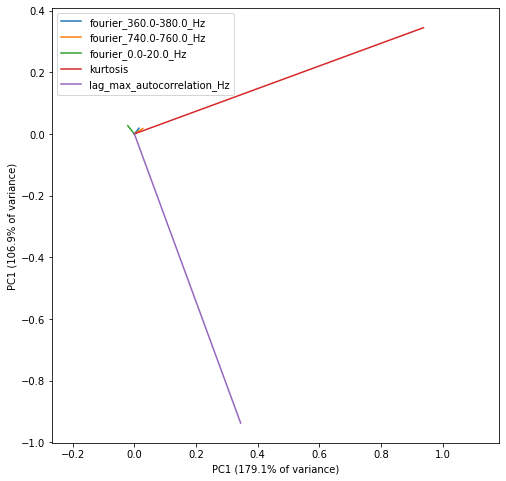

In [48]:
# plot the 2D projection of the top 5 features
fig, ax = fig_ax(figsize=(8, 8))
ax.axis("equal")
for feature_ind in top_features_for_pca:
    dx, dy = pca.components_.T[feature_ind]
    ax.plot([0, dx], [0, dy], label=all_features.columns[feature_ind])
ax.set_xlabel(f"PC1 ({pca.explained_variance_[0]:.1f}% of variance)")
ax.set_ylabel(f"PC1 ({pca.explained_variance_[1]:.1f}% of variance)")
_ = plt.legend()

## Supervised selection

Three main classes of methods:

- **Filter methods.** We test the adequacy of the feature with the annotations, thanks to several criterion/scores (e.g. correlation).
- **Wrapper methods.** We test the features on a supervised classification task, by trying several combinations. The best features are kept.
- **Embedded methods.** Mixed approaches where we jointly infer the relevance of the features and classify the data (decision tree, sparse methods...)


### Filter methods

If a feature is highly correlated with a label, it can help achieve good classification performance.

For classification tasks, ANOVA.

In [49]:
labels = data.y_train
statistics, pvalues = f_oneway(
    all_features[labels == "Abnormal"], all_features[labels == "Normal"]
)

In [50]:
for ind in statistics.argsort()[::-1]:
    print(f"{all_features.columns[ind]}: {statistics[ind]:.3f}")

max: 16.456
fourier_740.0-760.0_Hz: 14.957
min: 13.055
fourier_40.0-60.0_Hz: 12.309
autocorrelation_49_lag: 11.991
autocorrelation_14_lag: 11.314
autocorrelation_22_lag: 7.894
fourier_0.0-20.0_Hz: 6.644
autocorrelation_136_lag: 4.152
std: 2.934
autocorrelation_57_lag: 2.772
fourier_360.0-380.0_Hz: 2.462
fourier_60.0-80.0_Hz: 2.115
fourier_20.0-40.0_Hz: 1.938
autocorrelation_148_lag: 1.884
fourier_240.0-260.0_Hz: 1.821
fourier_80.0-100.0_Hz: 1.728
skew: 1.505
autocorrelation_124_lag: 1.199
lag_max_autocorrelation_Hz: 1.130
fourier_120.0-140.0_Hz: 1.053
autocorrelation_104_lag: 0.789
autocorrelation_195_lag: 0.786
autocorrelation_1_lag: 0.701
autocorrelation_71_lag: 0.434
autocorrelation_81_lag: 0.430
autocorrelation_95_lag: 0.396
autocorrelation_3_lag: 0.266
max_autocorrelation: 0.213
autocorrelation_62_lag: 0.169
autocorrelation_30_lag: 0.045
fourier_160.0-180.0_Hz: 0.041
kurtosis: 0.029
autocorrelation_157_lag: 0.014
autocorrelation_116_lag: 0.011
autocorrelation_89_lag: 0.000


### Wrapper methods

For a given learning algorithm, wrapper methods repeatedly select a subset of features and evaluate the selected features. Several procedures exist to select a subset but the most common are greedy and iterative; they either remove (backward selection) or add a feature (forward selection) sequentially.

In [52]:
# At each steps, SequentialFeatureSelector adds the best scoring feature to
# the set of selected features.
# For a given estimator, the score is computed with cross-validation.
knn = KNeighborsClassifier(n_neighbors=5)
sfs = SequentialFeatureSelector(
    knn, n_features_to_select=20, cv=5, scoring=make_scorer(accuracy_score)
)
sfs.fit(all_features, labels)

print("Selected features:")
print(all_features.columns[sfs.get_support()].tolist())

Selected features:
['autocorrelation_116_lag', 'autocorrelation_124_lag', 'autocorrelation_157_lag', 'autocorrelation_148_lag', 'autocorrelation_136_lag', 'autocorrelation_1_lag', 'autocorrelation_3_lag', 'min', 'fourier_740.0-760.0_Hz', 'autocorrelation_95_lag', 'autocorrelation_104_lag', 'skew', 'std', 'autocorrelation_71_lag', 'autocorrelation_89_lag', 'autocorrelation_81_lag', 'autocorrelation_195_lag', 'autocorrelation_57_lag', 'autocorrelation_62_lag', 'max_autocorrelation']


<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Run the same selection as above, but with backward selection (<tt>sklearn.feature_selection.RFE</tt>).</p>
</div>


In [53]:
from sklearn.feature_selection import RFE

In [59]:
# Let's try with a random forest
rf = RandomForestClassifier()
sfs = RFE(
    rf, n_features_to_select=20,
)
sfs.fit(all_features, labels)

print("Selected features:")
print(all_features.columns[sfs.get_support()].tolist())

Selected features:
['autocorrelation_116_lag', 'autocorrelation_148_lag', 'autocorrelation_136_lag', 'autocorrelation_14_lag', 'min', 'autocorrelation_22_lag', 'fourier_120.0-140.0_Hz', 'fourier_80.0-100.0_Hz', 'fourier_240.0-260.0_Hz', 'fourier_740.0-760.0_Hz', 'fourier_40.0-60.0_Hz', 'fourier_60.0-80.0_Hz', 'skew', 'std', 'max', 'autocorrelation_49_lag', 'autocorrelation_57_lag', 'autocorrelation_62_lag', 'lag_max_autocorrelation_Hz', 'max_autocorrelation']


### Embedded methods

Such methods use the intrinsic structure of a learning algorithm to embed feature selection into the underlying model.

In [60]:
rf = RandomForestClassifier().fit(all_features, labels)

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Print features in descending order of importance, measured by the random forest feature importance (see the <tt>feature_importances_</tt> attribute).</p>
</div>


In [61]:
list(all_features.columns[np.flip(np.argsort(rf.feature_importances_))])

['fourier_740.0-760.0_Hz',
 'std',
 'max',
 'min',
 'lag_max_autocorrelation_Hz',
 'autocorrelation_49_lag',
 'autocorrelation_14_lag',
 'fourier_60.0-80.0_Hz',
 'fourier_40.0-60.0_Hz',
 'autocorrelation_136_lag',
 'fourier_80.0-100.0_Hz',
 'autocorrelation_148_lag',
 'fourier_120.0-140.0_Hz',
 'autocorrelation_62_lag',
 'max_autocorrelation',
 'fourier_360.0-380.0_Hz',
 'skew',
 'fourier_240.0-260.0_Hz',
 'autocorrelation_3_lag',
 'autocorrelation_157_lag',
 'autocorrelation_22_lag',
 'autocorrelation_57_lag',
 'fourier_160.0-180.0_Hz',
 'autocorrelation_195_lag',
 'fourier_0.0-20.0_Hz',
 'autocorrelation_89_lag',
 'autocorrelation_104_lag',
 'autocorrelation_81_lag',
 'kurtosis',
 'autocorrelation_1_lag',
 'fourier_20.0-40.0_Hz',
 'autocorrelation_116_lag',
 'autocorrelation_124_lag',
 'autocorrelation_95_lag',
 'autocorrelation_71_lag',
 'autocorrelation_30_lag']